In [1]:
#Imports
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import glob
import pickle
import cv2
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import time

print('Imports done!')


Imports done!


### Loading dataset

In [2]:
car_images = glob.glob('test_images/vehicles/**/*.png')
noncar_images = glob.glob('test_images/non-vehicles/**/*.png')

print('No of Car Images     {} \nNo of Non-Car Images {}'.format(len(car_images), len(noncar_images)))

No of Car Images     8792 
No of Non-Car Images 8968


### Displaying Output : Image dataset
This is a random selection of Car and Non-Car images in the dataset used in this project

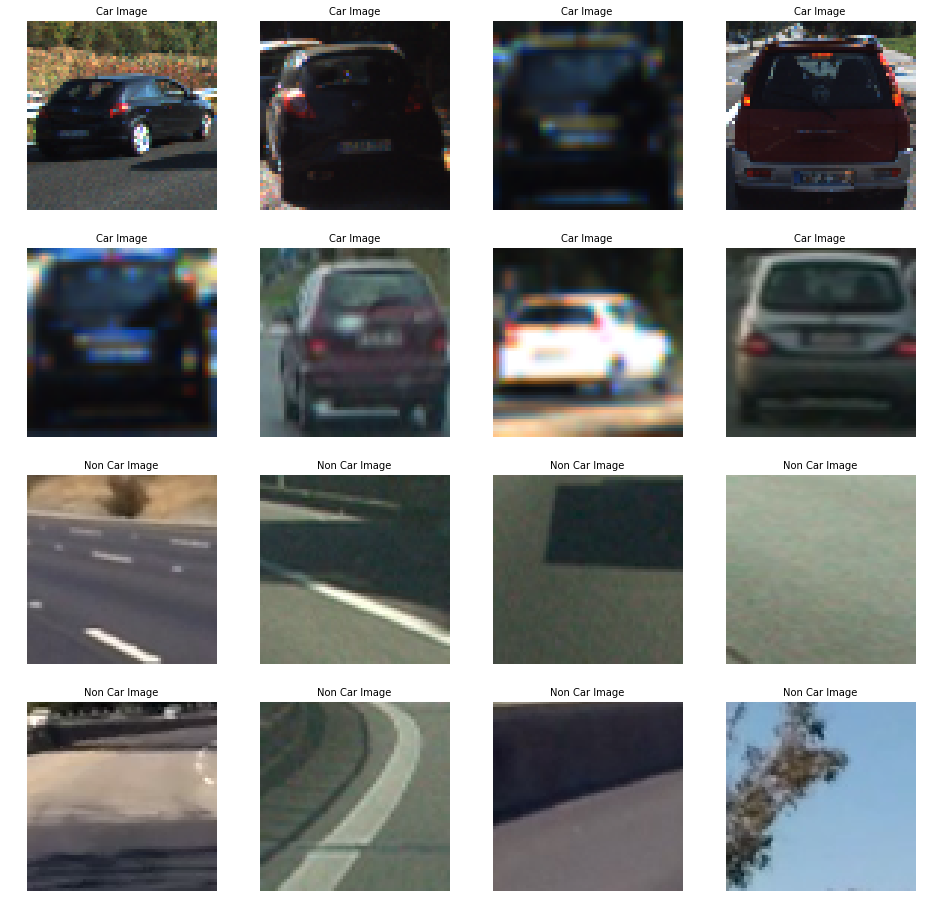

In [3]:
fig, axs = plt.subplots(4,4, figsize=(16, 16))
axs = axs.ravel() #This makes us to use only 1-D axs object. Otherwise, the axs should be axs[x, y] format

# Step through the list and search for chessboard corners
for i in range(8):
    img = cv2.imread(car_images[np.random.randint(0,len(car_images))])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    axs[i].axis('off')
    axs[i].set_title('Car Image', fontsize=10)
    axs[i].imshow(img)
for i in range(8,16):
    img = cv2.imread(noncar_images[np.random.randint(0,len(noncar_images))])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    axs[i].axis('off')
    axs[i].set_title('Non Car Image', fontsize=10)
    axs[i].imshow(img)

### Extracting Histogram of Oriented Gradients

In [4]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis, feature_vec=True):
    """
        This function uses the sklearn hog function to extract the HOG features of an image
    """
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block),
                                  block_norm= 'L2-Hys',
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else: 
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block),
                       block_norm= 'L2-Hys',
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

### Displaying Output : HOG Features

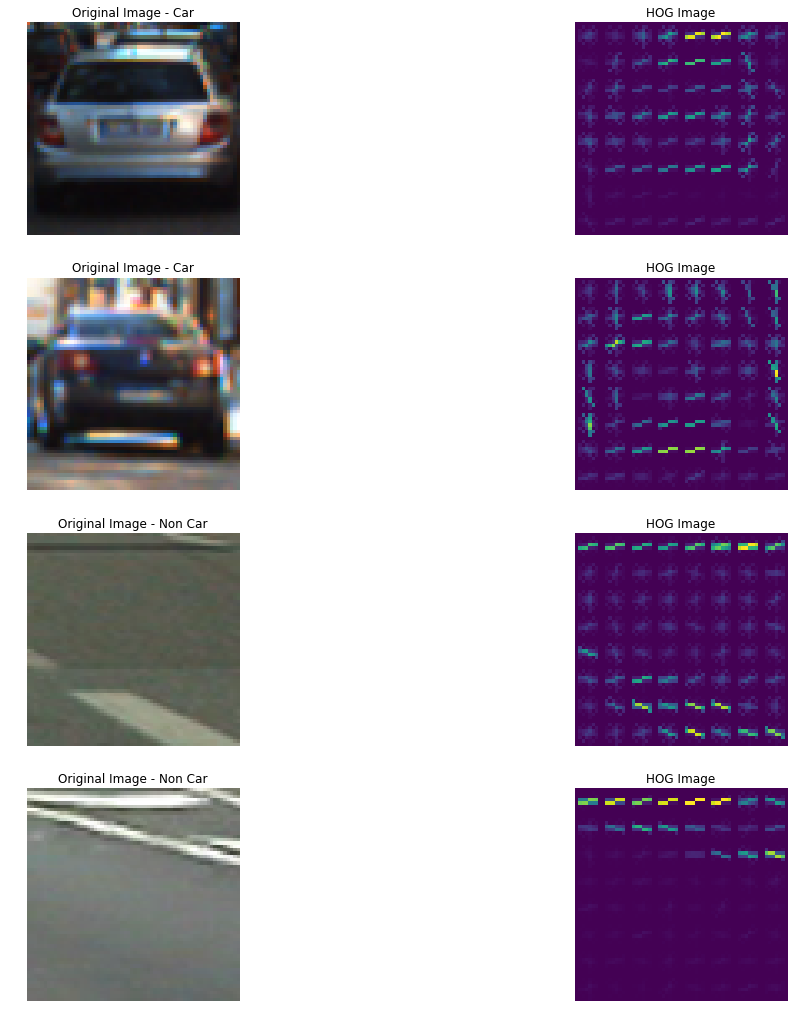

In [5]:
fig, axs = plt.subplots(4,2, figsize=(18, 18))
axs = axs.ravel() #This makes us to use only 1-D axs object. Otherwise, the axs should be axs[x, y] format

for i in range(2):
    img = mpimg.imread(car_images[np.random.randint(0, len(car_images))])
    hog_feature, hog_image = get_hog_features(img[:,:,2], 9, 8, 8, vis=True, feature_vec=True)
    axs[i*2].axis('off')
    axs[i*2].set_title('Original Image - Car')
    axs[i*2].imshow(img)
    axs[i*2+1].axis('off')
    axs[i*2+1].set_title('HOG Image')
    axs[i*2+1].imshow(hog_image)
for i in range(2,4):
    img = mpimg.imread(noncar_images[np.random.randint(0, len(noncar_images))])
    hog_feature, hog_image = get_hog_features(img[:,:,2], 9, 8, 8, vis=True, feature_vec=True)
    axs[i*2].axis('off')
    axs[i*2].set_title('Original Image - Non Car')
    axs[i*2].imshow(img)
    axs[i*2+1].axis('off')
    axs[i*2+1].set_title('HOG Image')
    axs[i*2+1].imshow(hog_image)    

### Spatial Binning of Color
Spatial binning is the down sampling of an image(meaning lower resolution). This helps with faster execution of hte process, and at the same time not losing too much information

In [6]:
def bin_spatial(img, color_space='RGB', size=(32, 32)):
    # Convert image to new color space (if specified)
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)             
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(feature_image, size).ravel() 
    # Return the feature vector
    return features

### Histogram of Colors

In [7]:
#Color Histogram
def color_hist(img, nbins=32):
    #If you observe, the bins_range is not required in the method signature here since we are working with png images
    # Compute the histogram of the RGB channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

### Basic helper functions

In [8]:
#Color conversion to various Color spaces
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

def visualize(fig, rows, cols, images, titles):
    for idx, img in enumerate(images):
        plt.subplot(rows, cols, idx+1)
        plt.title(idx+1)
        img_dims = len(img.shape)
        if img_dims < 3:
            plt.imshow(img, cmap='hot')
            plt.title(titles[idx])
        else:
            plt.imshow(img)
            plt.title(titles[idx])

### Combining features
The classifier will be more robust if we consider various features of the data that is useful. 

In this case, we are combining the following features
- Spatial Binning of the Image
- Histogram of Colors
- HOG Features

This process enables to hold more information of the same image compared to only considering a single feature
After all the features are extracted, they are stacked to a 1D vector

Note : The two methods defined below are exactly the same. The first method `extract_features` takes in a list of images at once which is used during training the classifier. Whereas the second method `single_img_features` takes in a single image and returns the features of it. This might be useful during runtime when the windows are processed one after the other and wants to evaluate the features

In [9]:
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))   
                hog_features = np.ravel(hog_features)
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True, visualize=False):
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)
        else:
            if visualize == True:
                hog_features, hog_image = get_hog_features(feature_image[:,:,hog_channel], orient, 
                                                pix_per_cell, cell_per_block, vis=True, feature_vec=True)
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                                                pix_per_cell, cell_per_block, vis=False, feature_vec=True)
                
        #8) Append features to list
        img_features.append(hog_features)
    #9) Return concatenated array of features
    if visualize == True:
        return np.concatenate(img_features), hog_image
    else:
        return np.concatenate(img_features)

### Determine windows in an image using sliding windows
This helper function slides the window of a specified shape over the span of the image that is selected and returns the bounding boxes for each of the windows. These can later be used to pass to the classifier to see if an image of interest is present or not

In [10]:
def slide_image_for_bboxes(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    """
        This method takes in an image, and pass the region of interest, window size and overlap
        Returns a list of bounding boxes
    """
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    #EXTRA - the following buffer lines are extra. In video, it is just xspan/nx_pix_per_step wihtout buffer
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    """
        For a given image and a list of bounding boxes,
        this method draws boxes using the inputs
    """
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

### Search Windows for Cars!
This method takes in the classifier, windows and other parameters and predicts if there is a car or not. If then returns all the bounding boxes where a car is found

In [11]:
def search_window_for_cars(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):
    """
        Given an image and the 
            list of windows(bounding boxes), 
            a trained Classifier, 
            Scaler(normalized per columns features)
        Step through each of the windows in the list, extract the subregion of the image
        resize the subregion(test window) to 64 * 64 (since training data is of that size)
        calls single_img_features to extract feature vectors,
        normalize the features using the same Sacler that was fit using the training data
        predict if this window contains a car and add it to car windows list
        return the list of bounding boxes for Car predictions
    """

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

### Displaying Output : Extracting Features
This is to visualize the data using the functions defined

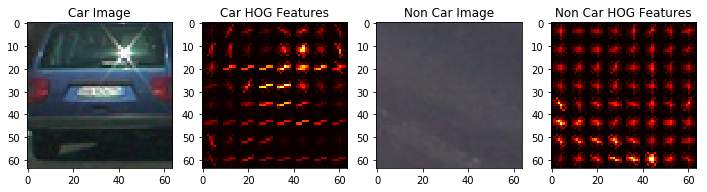

In [12]:
car_image_name = car_images[np.random.randint(0, len(car_images))]
noncar_image_name = noncar_images[np.random.randint(0, len(noncar_images))]

car_image = mpimg.imread(car_image_name)
noncar_image = mpimg.imread(noncar_image_name)

#For Spatial Binning
color_space='RGB'
spatial_size=(16, 16)
#For Color Histogram
hist_bins=16
#For HOG
orient=9
pix_per_cell=8
cell_per_block=2
hog_channel=1
#For combining features
spatial_feat=True
hist_feat=True
hog_feat=True

car_features, car_hog_image = single_img_features(car_image, color_space, spatial_size,
                        hist_bins, orient, pix_per_cell, cell_per_block, hog_channel,
                        spatial_feat, hist_feat, hog_feat, True)
noncar_features, noncar_hog_image = single_img_features(noncar_image, color_space, spatial_size,
                        hist_bins, orient, pix_per_cell, cell_per_block, hog_channel,
                        spatial_feat, hist_feat, hog_feat, True)

images = [car_image, car_hog_image, noncar_image, noncar_hog_image]
titles = ['Car Image', 'Car HOG Features', 'Non Car Image', 'Non Car HOG Features']

fig = plt.figure(figsize=(12,9))
visualize(fig, 1, 4, images, titles)

### Training a Classifier

Results :
For 1000 random samples of Car & Non Car each,
- For RGB with 9 orientations, the classifier gave an accuracy of 94%
- For YCrCb with 9 orientations, the classifier gave an accuracy of 98.75%
On the full training set, for YCrCb with 9 orientations, the classifier gave an accuracy of 97.13%

In [13]:
# Defining a sample set for testing
#sample_size = 50
#random_idxs = np.random.randint(0, len(car_images), sample_size)
sample_car_images = car_images #np.array(car_images)[random_idxs]
sample_noncar_images = noncar_images #np.array(noncar_images)[random_idxs]

#For Spatial Binning
color_space='YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
spatial_size=(32, 32)
#For Color Histogram
hist_bins=32
#For HOG
orient=9
pix_per_cell=8
cell_per_block=2
hog_channel='ALL'
#For combining features
spatial_feat=True
hist_feat=True
hog_feat=True
#y_start_stop = [400, 720] # Min and max in y to search in slide_image_for_bboxes()
t1=time.time()

car_features = extract_features(sample_car_images, color_space=color_space, 
                                spatial_size=spatial_size, hist_bins=hist_bins, orient=orient, 
                                pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                                hog_channel=hog_channel, spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)


noncar_features = extract_features(sample_noncar_images, color_space=color_space, 
                                spatial_size=spatial_size, hist_bins=hist_bins, orient=orient, 
                                pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                                hog_channel=hog_channel, spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)
t2 = time.time()
print(t2 - t1, ' Seconds to compute features...')

# Create an array stack of feature vectors
X = np.vstack((car_features, noncar_features)).astype(np.float64)
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_x = X_scaler.transform(X)
#scaled_y = X_scaler.transform(X_test)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(noncar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_x, y, test_size=0.2, random_state=rand_state)
    
print('Using:',orient,'orientations',pix_per_cell, 'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

# CLASSIFIER - SUPPORT VECTOR MACHINE - LINEAR CLASSIFIER
svc = LinearSVC()
svc.fit(X_train, y_train)
t3 = time.time()
print(round(t3-t2, 2), ' Seconds to train SVC...')

# Accuracy Prediction
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

319.6143682003021  Seconds to compute features...
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 8460
117.07  Seconds to train SVC...
Test Accuracy of SVC =  0.9899


### Saving the classifier to a pickle

In [17]:
clf_pickle = {}
clf_pickle['classifier'] = svc
clf_pickle['X_scaler'] = X_scaler
pickle.dump(clf_pickle, open("data/classifier.p", 'wb'))
print('...')

...


### Testing the classifier on sample Images

2.924 Seconds to slide through an image with 5 window findings
1.053 Seconds to slide through an image with 1 window findings
1.117 Seconds to slide through an image with 1 window findings
1.077 Seconds to slide through an image with 5 window findings
1.136 Seconds to slide through an image with 8 window findings
1.246 Seconds to slide through an image with 7 window findings


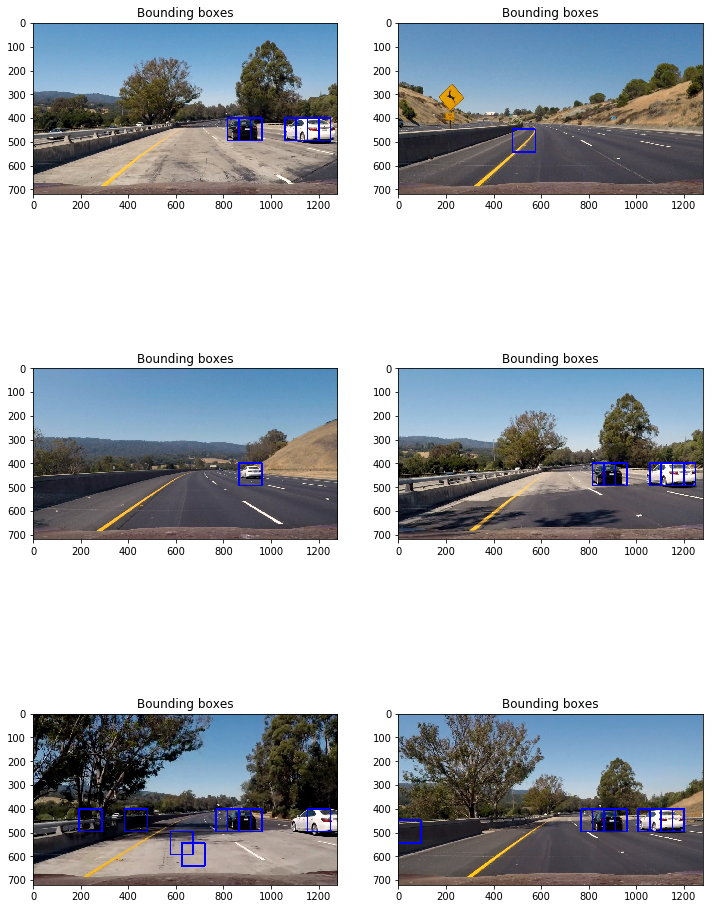

In [18]:
images = glob.glob('test_images/test*.jpg')
#hog_channel = 'ALL'
draw_images = []
images_for_display = []
titles = []

#For determining bounding boxes
y_start_stop = [400, 680]
overlap = 0.5
window_width = 96

for ii in range(len(images)):
    t1 = time.time()
    img = mpimg.imread(images[ii])
    draw_image = np.copy(img)
    #Since the test images are in JPEG format, we need to divide by 255 to make it to [0, 1] which is PNG
    img = img.astype(np.float32)/255

    windows = slide_image_for_bboxes(img, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                        xy_window=(window_width, window_width), xy_overlap=(overlap, overlap))

    #To call this function, you need the classifier and X_scaler available, which in our case is determined above
    hot_windows = search_window_for_cars(img, windows, svc, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, orient=orient, 
                            pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel, 
                            spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)

    window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6) 
    images_for_display.append(window_img)
    titles.append('Bounding boxes')
    t2 = time.time()
    print('{:.3f} Seconds to slide through an image with {} window findings'.format(t2-t1, len(hot_windows)))

fig = plt.figure(figsize=(12, 18))
visualize(fig, 3, 2, images_for_display, titles)

### Extrating HOG Features at once and subsampling

It is clear that if we extreact features for each individual window seperately, the process is very slow.
Instead what we can do is to extreact the features of the whole image at once and subsample it so that we aren't wasting time 
in extracting features one after the other with so much overlap

In [19]:
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):

    

    draw_img = np.copy(img)
    #Input is JPEG but the classifier is trained on PNG, hence changing the range to [0, 1]
    img = img.astype(np.float32)/255

    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    
    #Define a heat map
    heatmap = np.zeros_like(img[:,:,0])

    
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))

    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2

    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1

    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=False)
    
    #print('Window Size {} Scale {}'.format(spatial_size, scale))
    bboxes = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))

            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)
            #print(spatial_features.shape, hist_features.shape,hog_features.shape)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)

            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                bboxes.append(((xbox_left, ytop_draw+ystart), (xbox_left+win_draw,ytop_draw+win_draw+ystart)))
    return draw_img, bboxes

### Dealing with False Positives

In [20]:
from scipy.ndimage.measurements import label

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

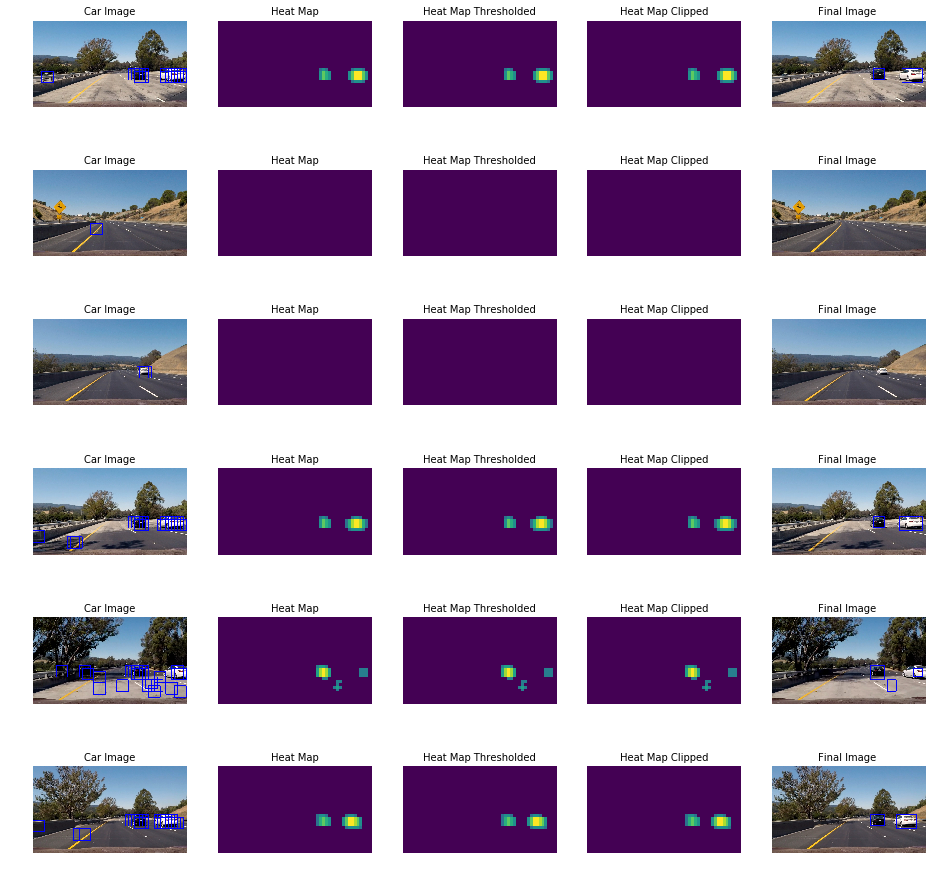

In [30]:
ystart = 400
ystop = 680
scale = 1.5
images = glob.glob('test_images/test*.jpg')
draw_images = []
for ii in range(len(images)):
    img = mpimg.imread(images[ii])
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    
    out_img, bboxes = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    draw_images.append(out_img)
    
    # Add heat to each box in box list
    heat = add_heat(heat, bboxes)
    draw_images.append(heat)
    
    # Apply threshold to help remove false positives
    heat_th = apply_threshold(heat, 2)
    draw_images.append(heat_th)
    
    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat_th, 0, 255)
    draw_images.append(heatmap)
    
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    final_img = draw_labeled_bboxes(np.copy(img), labels)
    draw_images.append(final_img)
    
    
    
    
fig, axs = plt.subplots(6,5, figsize=(16, 16))
axs = axs.ravel() #This makes us to use only 1-D axs object. Otherwise, the axs should be axs[x, y] format
# Step through the list and search for chessboard corners
for i in range(6):
    axs[(5*i)].axis('off')
    axs[(5*i)].set_title('Car Image', fontsize=10)
    axs[(5*i)].imshow(draw_images[5*i])
    axs[(5*i)+1].axis('off')
    axs[(5*i)+1].set_title('Heat Map', fontsize=10)
    axs[(5*i)+1].imshow(draw_images[(5*i)+1])
    axs[(5*i)+2].axis('off')
    axs[(5*i)+2].set_title('Heat Map Thresholded', fontsize=10)
    axs[(5*i)+2].imshow(draw_images[(5*i)+2])
    axs[(5*i)+3].axis('off')
    axs[(5*i)+3].set_title('Heat Map Clipped', fontsize=10)
    axs[(5*i)+3].imshow(draw_images[(5*i)+3])
    axs[(5*i)+4].axis('off')
    axs[(5*i)+4].set_title('Final Image ', fontsize=10)
    axs[(5*i)+4].imshow(draw_images[(5*i)+4])
    

### Final Pipeline
This pipeline just uses various functions defined above into a single function

In [ ]:
def process_image(img):
    out_img, bboxes = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, 
                                spatial_size, hist_bins)
    labels = label(heatmap)
    final_img = draw_labeled_bboxes(np.copy(img), labels)
    return final_img

In [ ]:
print('ravi')

